# Прогнозирование количества заказов такси на следующий час

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Описание данных

Файл ***/datasets/taxi.csv***. Столбцы:


- **datetime** - дата и время   
- **num_orders** - количество заказов


# 1. Подготовка данных

Импорт модулей:

In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import catboost as cb
import xgboost as xgb
import lightgbm as lgb

R=10000

Откроем полученный датасет. Столбец с датой и временем сразу преобразуем в Datetime и установим в качестве индекса:

In [215]:
dirname = './datasets/'
taxi = pd.read_csv(dirname + 'taxi.csv', parse_dates=True, index_col=0)

taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, упорядочены ли записи по времени (индексу):

In [216]:
taxi.index.is_monotonic

True

Посмотрим информацию о таблице:

In [217]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В таблице содержится 26496 записей. Период измерений - 10 минут, диапазон записей - с 1 марта по 31 августа 2018 года. Тип целевой переменной - целочисленный.   

Произведем ресэмплинг - зададим в качестве интервала 1 час:

In [218]:
taxi = taxi.resample('1H').sum()
print('Количество записей после ресэмплинга:', taxi.shape[0])

Количество записей после ресэмплинга: 4416


# 2. Анализ данных

Построим график количества заказов в зависимости от времени:

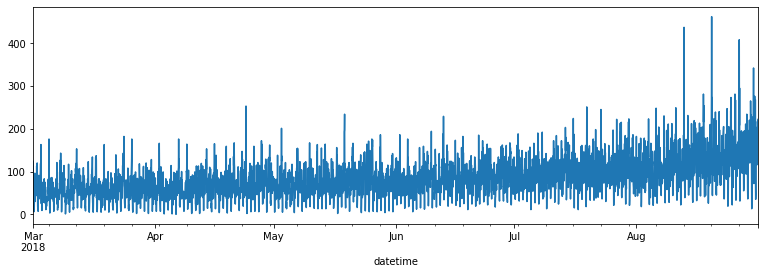

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


In [219]:
taxi['num_orders'].plot(figsize=(13,4))
plt.show()
taxi.describe().transpose()

Целевая переменная принимает значения от 0 до 462 со средним в районе 84 заказов в час и стандартным отклонением в 45.

Разложим наш временной ряд на тренд и сезонные колебания с помощью функции seasonal_decompose из модуля statsmodels:

In [220]:
decomposed = seasonal_decompose(taxi)

Построим графики для каждой составляющей:

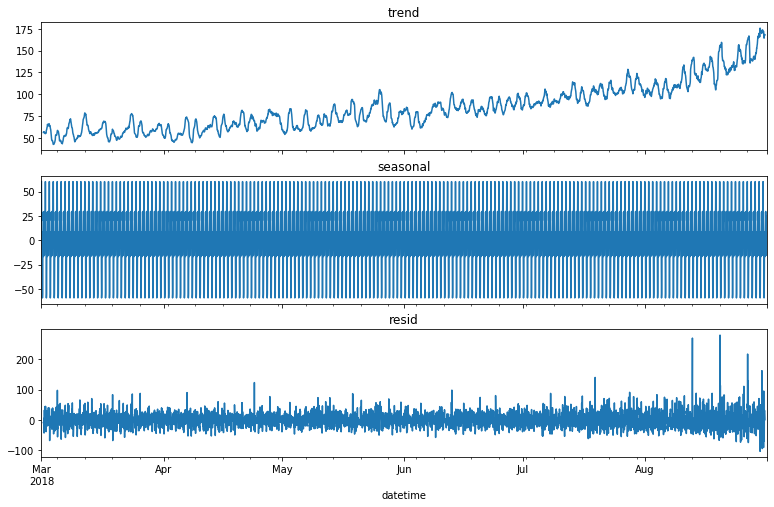

In [221]:
elements = [decomposed.trend, decomposed.seasonal, decomposed.resid]
fig, axes = plt.subplots(3, 1, figsize=(13, 8), sharex=True)
for element, ax in zip(elements, axes.ravel()):
    element.plot(ax=ax)
    ax.set_title(element.name)

По графику тренда можно видеть, что целевая переменная зависит от месяца (среднее количество заказов растет с течением времени). Очевидно, что с приближением лета увеличивается пассажиропоток аэропорта, а следовательно и количество заказов такси. Также отметим, что временной ряд остатков достаточно стационарен (если не считать некоторых выбросов в правой части). Это хорошо, значит, шумы будут меньше влиять на работу моделей.

Что касается сезонности, рассмотрим ее колебания на меньшем масштабе:

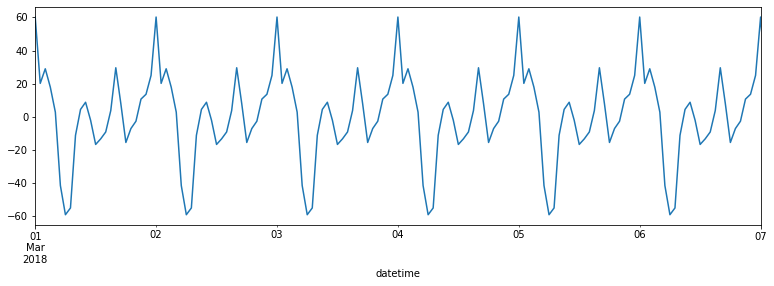

In [222]:
decomposed.seasonal.plot(xlim=('2018-03-01', '2018-03-07'), figsize=(13,4))
plt.show()

Можно заметить, что колебания переменной происходят в течение 24 часов, что логично, поскольку вызовы такси связаны с временем суток и прибытием рейсов в течение дня. Разброс при этом весьма значителен - около 120 заказов в час.

Проверим, есть ли циклические колебания переменной на более крупных временных масштабах. Для этого ресэмплируем данные по дню (чтобы избавиться от колебаний в течение суток) и построим график сезонности:

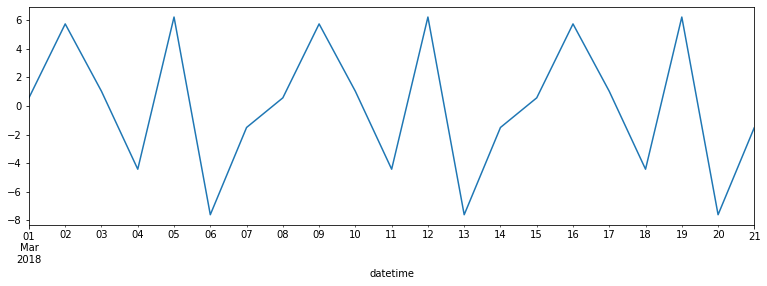

In [223]:
seasonal_days = seasonal_decompose(taxi.resample('1D').mean()).seasonal
seasonal_days.plot(xlim=('2018-03-01', '2018-03-21'), figsize=(13,4))
plt.show()

Видим, что количество заказов такси также зависит и от дня недели, что тоже логично. При этом колебания в течение недели намного менее выражены, чем суточные (в среднем разница составляет всего 14-15 заказов в час)

# 3. Подготовка данных

### Создание признаков

С учетом произведенного анализа добавим в таблицу столбцы с календарными признаками: месяцем, числом, днем недели и часом (мы видели, что все они могут влиять на целевую переменную).

In [224]:
taxi['month'] = taxi.index.month
taxi['day'] = taxi.index.day
taxi['weekday'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour
taxi.head()

,num_orders,month,day,weekday,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4


Заметим, что добавленные столбцы являются категориальными признаками, и их числовое представление может ухудшить работу регрессоров. Закодируем каждый из них средним значением целевой переменной по каждой категории. При этом следует учесть, что в рассчете среднего не должна участвовать тестовая часть датасета:

In [225]:
def encode_categories_by_mean(category):
    stop_index = int(taxi.shape[0] * 0.9)    #ограничим рассчет средних тренировочным набором
    means_dict = dict(taxi.iloc[:stop_index].groupby(category)['num_orders'].mean())
    for i in means_dict.keys():
        taxi.loc[taxi[category] == i, category] = means_dict[i]

    
for cat in ['month', 'day', 'weekday', 'hour']:
    encode_categories_by_mean(cat)

Поскольку нам требуется предсказать количество вызовов такси на час вперед, считаем, что данные за предыдущие часы известны. Создадим из них дополнительные признаки: значения переменной со сдвигом от одного до пяти часов назад, а также скользящее среднее за последние сутки:

In [226]:
def add_features(max_shift, rolling_size):
    data = taxi[taxi.columns] 
    for s in range(1, max_shift + 1):
        data['shift' + str(s)] = data['num_orders'].shift(s, fill_value=data.iloc[0,0])
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size, min_periods=1).mean()
    data = data.dropna()
    return data
    
taxi = add_features(5, 24)
taxi

,num_orders,month,day,weekday,hour,shift1,shift2,shift3,shift4,shift5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 01:00:00,85,57.483871,72.347222,78.276042,95.734940,124,124,124,124,124,124.000000
2018-03-01 02:00:00,71,57.483871,72.347222,78.276042,103.240964,85,124,124,124,124,104.500000
2018-03-01 03:00:00,66,57.483871,72.347222,78.276042,94.385542,71,85,124,124,124,93.333333
2018-03-01 04:00:00,43,57.483871,72.347222,78.276042,77.939759,66,71,85,124,124,86.500000
2018-03-01 05:00:00,6,57.483871,72.347222,78.276042,39.451807,43,66,71,85,124,77.800000
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,110.228477,81.513889,84.105903,72.872727,207,217,197,116,133,164.875000
2018-08-31 20:00:00,154,110.228477,81.513889,84.105903,78.024242,136,207,217,197,116,167.541667
2018-08-31 21:00:00,159,110.228477,81.513889,84.105903,88.575758,154,136,207,217,197,168.041667


Поскольку, сезонность проявляется на отрезках в сутки и неделю, добавим также столбцы со значениями целевой переменной в то же время один, два и три дня (недели) назад:

In [227]:
for i in range(1, 4):
    taxi[str(i) +'_day_shift'] = taxi['num_orders'].shift(24 * i, fill_value=taxi.iloc[0,0])
    taxi[str(i) +'_week_shift'] = taxi['num_orders'].shift(24 * 7 * i, fill_value=taxi.iloc[0,0])
taxi.head()

,num_orders,month,day,weekday,hour,shift1,shift2,shift3,shift4,shift5,rolling_mean,1_day_shift,1_week_shift,2_day_shift,2_week_shift,3_day_shift,3_week_shift
datetime,,,,,,,,,,,,,,,,,
2018-03-01 01:00:00,85,57.483871,72.347222,78.276042,95.734940,124,124,124,124,124,124.000000,85,85,85,85,85,85
2018-03-01 02:00:00,71,57.483871,72.347222,78.276042,103.240964,85,124,124,124,124,104.500000,85,85,85,85,85,85
2018-03-01 03:00:00,66,57.483871,72.347222,78.276042,94.385542,71,85,124,124,124,93.333333,85,85,85,85,85,85
2018-03-01 04:00:00,43,57.483871,72.347222,78.276042,77.939759,66,71,85,124,124,86.500000,85,85,85,85,85,85
2018-03-01 05:00:00,6,57.483871,72.347222,78.276042,39.451807,43,66,71,85,124,77.800000,85,85,85,85,85,85


Выделим целевой признак в переменную ***target***, а остальные сохраним в ***features***:

In [228]:
features = taxi.drop(columns = ['num_orders'])
target = taxi['num_orders']

Разобьем данные на обучающую и тестовую выборки (без перемешивания):

In [229]:
train_feats, test_feats, train_target, test_target = train_test_split(features, 
                                                                      target,
                                                                      train_size=0.9,
                                                                      shuffle=False)
print(f'''Размеры выборок:

Обучающая \t {train_feats.shape[0]}
Тестовая \t {test_feats.shape[0]}''')

Размеры выборок:

Обучающая 	 3973
Тестовая 	 442


Посмотрим на тепловую карту корреляций признаков:

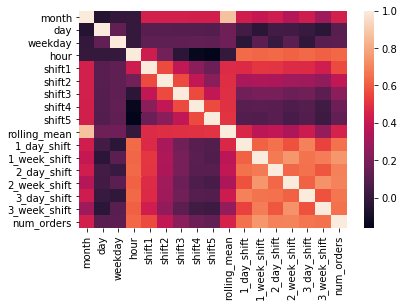

In [230]:
sns.heatmap(train_feats.join(train_target).corr())
plt.show()

Произведем отбор 13 наиболее важных признаков по критерию хи-квадрат:

In [231]:
select = SelectKBest(chi2, k=13)
select.fit(train_feats, train_target)
train_feats = select.transform(train_feats)
test_feats = select.transform(test_feats)
train_feats.shape

(3973, 13)

# 3. Обучение моделей

### Linear Regression

В качестве базовой модели, с которой мы будем сравнивать качество работы наших регрессоров, используем линейную регрессию:

Результаты:
 RMSE на тренировочных данных: 21.0626, RMSE на тестовых данных: 33.8898,
 время обучения: 0.0012 с.


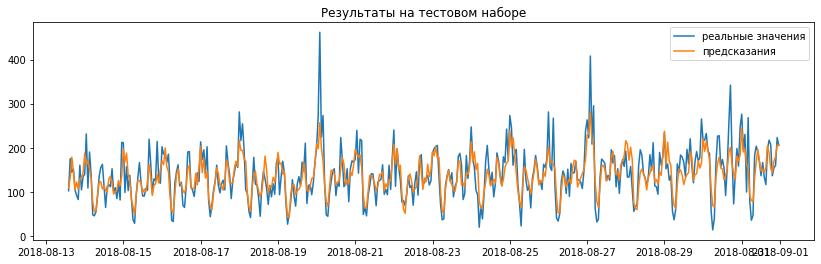

In [232]:
def model_quick_test(model, plot=None, silent=None):
    t_0 = time()
    model.fit(train_feats, train_target)
    t_fit = time() - t_0
    train_pred = model.predict(train_feats)
    train_rmse = mean_squared_error(train_pred, train_target) ** 0.5
    test_pred = model.predict(test_feats)
    test_rmse = mean_squared_error(test_pred, test_target) ** 0.5
    if not silent:
        print('Результаты:\n',
              f'RMSE на тренировочных данных: {round(train_rmse, 4)}, RMSE на тестовых данных: {round(test_rmse, 4)},\n',
              f'время обучения: {round(t_fit, 4)} с.')
    if plot:                                       #график
        plt.figure(figsize=(14, 4))
        plt.plot(test_target, label="реальные значения")
        plt.plot(test_target.index, test_pred, label="предсказания")
        plt.legend(loc="best")
        plt.title('Результаты на тестовом наборе')
        plt.show()
    return train_rmse, test_rmse, t_fit


results = pd.DataFrame(columns=['RMSE на тренировочном наборе', 
                                'RMSE на тестовом наборе', 
                                'Время обучения'])
results.loc['Linear Regression'] = model_quick_test(LinearRegression(), plot=1)

Как видим, линейная регрессия в целом показывает весьма неплохой результат, который уже укладывается в требования задания (RMSE меньше 48). 

### Random Forest

Попробуем обучить модель на основе алгоритма "Случайный лес"

Результаты:
 RMSE на тренировочных данных: 7.9158, RMSE на тестовых данных: 37.2743,
 время обучения: 2.1637 с.


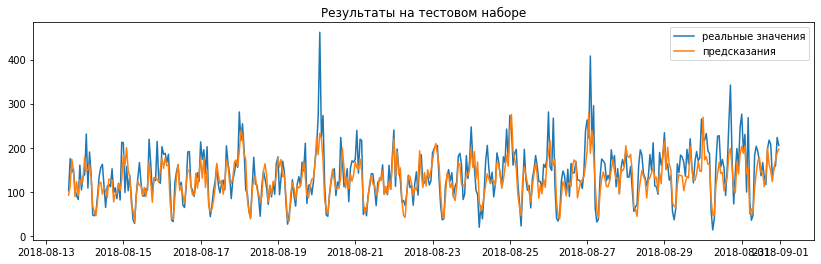

In [233]:
results.loc['Random Forest'] = model_quick_test(RandomForestRegressor(n_estimators= 100, random_state=123), plot=1)

У случайного леса результат вышел чуть похуже линейной регрессии.

### Градиентный бустинг

Наконец, рассмотрим модель на основе градиентного бустинга. Воспользуемся пакетом Light GBM.
Быстро оценим качество работы регрессора:

In [234]:
model = lgb.LGBMRegressor(random_state=R)
_ = model_quick_test(model)

Результаты:
 RMSE на тренировочных данных: 13.5122, RMSE на тестовых данных: 37.2685,
 время обучения: 0.0996 с.


Результат получен неплохой, но также хуже, чем для линейной регрессии. Подберем оптимальные гиперпараметры для LGBM-регрессора.

Воспользуемся решетчатым поиском. Зададим пространство параметров:

In [235]:
param_grid = {'learning_rate': [0.03, 0.01, 0.005],
              'n_estimators': [100, 500, 600],
              'max_depth': [2, 3, 4],
              'reg_lambda': [0, 0.1, 1],
              'bagging_fraction': [0.5, 1],
              'feature_fraction': [0.4, 0.5],} 

Стандартный метод кроссвалидации по фолдам для временных рядов не подходит, используем для разбиения сплиттер TimeSeriesSplit:

In [236]:
tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
grid.fit(train_feats, train_target)
print('Лучшая метрика на кросс-валидации:', grid.best_score_*(-1), ', оптимальные гиперпараметры:')
for x in grid.best_params_:
    print(x, ':', grid.best_params_[x])

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:   15.2s


Лучшая метрика на кросс-валидации: 21.996318622585544 , оптимальные гиперпараметры:
bagging_fraction : 0.5
feature_fraction : 0.4
learning_rate : 0.01
max_depth : 3
n_estimators : 600
reg_lambda : 0.1


[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:   22.7s finished


Проверим качество работы модели с подобранными параметрами на тестовой выборке:

Результаты:
 RMSE на тренировочных данных: 19.304, RMSE на тестовых данных: 37.0214,
 время обучения: 0.1697 с.


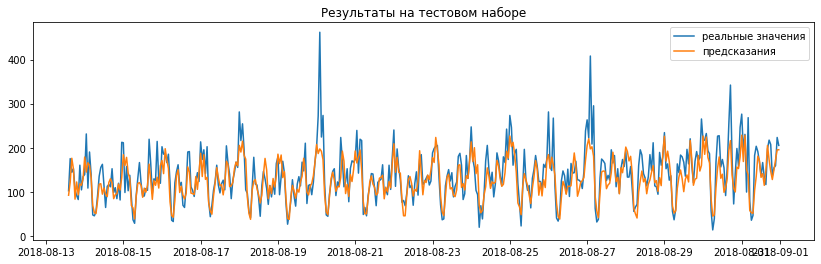

In [237]:
model = lgb.LGBMRegressor(**grid.best_params_)
results.loc['Gradient Boosting'] = model_quick_test(model, plot=1)

### Опорные вектора
Попробуем также обучить модель на основе алгоритма опорных векторов:

Результаты:
 RMSE на тренировочных данных: 21.3824, RMSE на тестовых данных: 36.4558,
 время обучения: 0.6112 с.


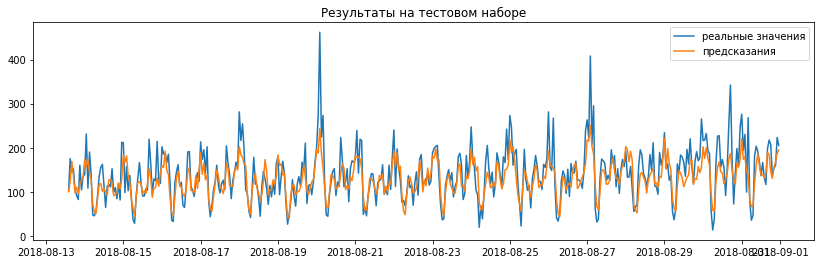

In [238]:
from sklearn.svm import SVR
svr_model = SVR(C=50, gamma=0.000001, kernel='sigmoid')
results.loc['SVR'] = model_quick_test(svr_model, plot=1)

# 5. Итоги
В итоге мы получили следующие результаты:

In [239]:
results.sort_values('RMSE на тестовом наборе')

,RMSE на тренировочном наборе,RMSE на тестовом наборе,Время обучения
Linear Regression,21.062575,33.889816,0.001234
SVR,21.382358,36.455837,0.611212
Gradient Boosting,19.304048,37.021354,0.169749
Random Forest,7.915770,37.274317,2.163693


Как видно, наилучший результат в этой задаче показала модель линейной регрессии (ошибка на тестовых данных составила всего 34 заказа). При этом все модели уложились в требования задания (RMSE менее 48).